pet sitter customer segments
===
# introduction
now let us look at the pet sitters in isolation. we know lots of properties of those:

pet sitter profiles augmented table has a number of useful fields for clustering

## numerical features:
- nb_reviews                         type:  uint16  
- nb_5s_reviews                      type:  uint16  
- nb_applications                    type:  uint16  
- nb_sits_completed                  type:  uint16  
- nb_domestic_sits                   type:  uint16  
- nb_local_sits                      type:  uint16  
- nb_sits_booked                     type:  uint16  
- nb_of_sitter_pets                  type:  uint16  
- daily_minutes_willing_to_walk_dogs type:  int16   
- days_since_modified                type:  Int16   
- birth_decade                       type:  Int16   
- partner_birth_decade               type:  Int16   
- five_star_ratio                    type:  float32 

## categorical features
- country                            type:  category 
- travelling_as                      type:  category
- occupation_type                    type:  category

## boolean features
- with_children                      type:  bool    
- sitting_with_another               type:  bool    
- prev_sitting_experience            type:  bool    
- other_animals                      type:  bool    
- has_dog_experience                 type:  bool    
- has_cat_experience                 type:  bool    
- has_reptile_experience             type:  bool    
- has_horse_experience               type:  bool    
- has_fish_experience                type:  bool    
- has_poultry_experience             type:  bool    
- has_farm_animal_experience         type:  bool    
- has_bird_experience                type:  bool    
- has_small_pet_experience           type:  bool    
- prefers_all_countries              type:  bool    
- years_of_experience                type:  int8    
- happy_to_meet_in_person            type:  bool    
- happy_to_video_call                type:  bool    
- interested_in_remote_working       type:  bool    
- interested_in_dogs                 type:  bool    
- interested_in_cats                 type:  bool    
- interested_in_reptiles             type:  bool    
- interested_in_horses               type:  bool    
- interested_in_fish                 type:  bool    
- interested_in_poultry              type:  bool    
- interested_in_farm_animals         type:  bool    
- interested_in_birds                type:  bool    
- interested_in_small_pets           type:  bool    
- with_a_baby                        type:  bool    
- with_a_toddler                     type:  bool    
- with_a_child                       type:  bool    
- with_a_teen                        type:  bool    
- dog_skills                         type:  bool    
- cat_skills                         type:  bool    
- can_give_medicine                  type:  bool    
- big_dog_preferences                type:  bool    
- small_dog_preferences              type:  bool    
- wish_list_city                     type:  bool    
- wish_list_beach                    type:  bool    
- wish_list_mountain                 type:  bool    
- wish_list_countryside              type:  bool    

considering this highly multidimensional let's explore what groups and grouping are there between them? 

In [2]:
import duckdb
import gower
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from   sklearn.decomposition  import PCA
from   sklearn.metrics        import DistanceMetric
from   sklearn.metrics        import silhouette_score
from   sklearn.preprocessing  import LabelEncoder
from   sklearn_extra.cluster  import KMedoids
import umap
DATABASEFILE='../data/sits.ddb'  # path to persistent duckdb database file
INPROGRESS='../data/inprogress/' # path to folder for caching intermediate data products

# fetch data

In [3]:
with duckdb.connect(DATABASEFILE) as con:
    profiles_df = con.sql("SELECT * FROM profiles_prep").fetchdf()

profiles_df.columns, len(profiles_df.columns)

(Index(['id', 'user_id', 'pct_complete', 'travelling_as', 'with_children',
        'sitting_with_another', 'occupation_type', 'prev_sitting_experience',
        'other_animals', 'has_dog_experience', 'has_cat_experience',
        'has_reptile_experience', 'has_horse_experience', 'has_fish_experience',
        'has_poultry_experience', 'has_farm_animal_experience',
        'has_bird_experience', 'has_small_pet_experience',
        'prefers_all_countries', 'nb_reviews', 'nb_5s_reviews',
        'nb_applications', 'nb_sits_completed', 'nb_domestic_sits',
        'nb_local_sits', 'nb_sits_booked', 'years_of_experience',
        'nb_of_sitter_pets', 'daily_minutes_willing_to_walk_dogs',
        'happy_to_meet_in_person', 'happy_to_video_call',
        'interested_in_remote_working', 'interested_in_dogs',
        'interested_in_cats', 'interested_in_reptiles', 'interested_in_horses',
        'interested_in_fish', 'interested_in_poultry',
        'interested_in_farm_animals', 'interested_in_b

# data preparation

In [32]:
profiles_df.dtypes.value_counts()

int64      42
uint16      8
uint32      2
int16       2
float64     2
uint8       1
int8        1
float32     1
Name: count, dtype: int64

In [31]:
categorical_features = list(profiles_df.select_dtypes(include=['bool', 'category']).columns)
numerical_features   = list(profiles_df.select_dtypes(include=['int8','uint8','uint16', 'Int16', 'float32', 'float64']).columns) # exclude uint32 (non-feature id columns)

In [6]:
# encoders for categorical variables
encoders = {}
for cat_col in categorical_features:
    if cat_col in profiles_df.columns:
        encoders[cat_col] = LabelEncoder()
        profiles_df[cat_col] = encoders[cat_col].fit_transform(profiles_df[cat_col])


In [7]:
# collect feature columns
feature_columns = []
feature_columns.extend(categorical_features)
feature_columns.extend(numerical_features)
# ensure all features are included in the DataFrame
feature_columns = [col for col in feature_columns if col in profiles_df.columns]
# feature type array (1 for categorical, 0 for numeric)
feature_types = [1 if col in categorical_features else 0 for col in feature_columns]


# gower distance matrix calculations

In [28]:
feature_columns

['travelling_as',
 'with_children',
 'sitting_with_another',
 'occupation_type',
 'prev_sitting_experience',
 'other_animals',
 'has_dog_experience',
 'has_cat_experience',
 'has_reptile_experience',
 'has_horse_experience',
 'has_fish_experience',
 'has_poultry_experience',
 'has_farm_animal_experience',
 'has_bird_experience',
 'has_small_pet_experience',
 'prefers_all_countries',
 'happy_to_meet_in_person',
 'happy_to_video_call',
 'interested_in_remote_working',
 'interested_in_dogs',
 'interested_in_cats',
 'interested_in_reptiles',
 'interested_in_horses',
 'interested_in_fish',
 'interested_in_poultry',
 'interested_in_farm_animals',
 'interested_in_birds',
 'interested_in_small_pets',
 'with_a_baby',
 'with_a_toddler',
 'with_a_child',
 'with_a_teen',
 'dog_skills',
 'cat_skills',
 'can_give_medicine',
 'big_dog_preferences',
 'small_dog_preferences',
 'wish_list_city',
 'wish_list_beach',
 'wish_list_mountain',
 'wish_list_countryside',
 'pct_complete',
 'nb_reviews',
 'nb_5s_

In [8]:
%%time
gower_dist = gower.gower_matrix(profiles_df[feature_columns], cat_features=feature_types)

CPU times: user 3min 24s, sys: 40.7 s, total: 4min 5s
Wall time: 4min 6s


In [9]:
gower_dist.shape

(33352, 33352)

In [10]:
# save a copy of the distance matrix
with open(INPROGRESS+'gower_distance.pickle', 'wb+') as fh:
    pickle._dump(gower_dist, fh, protocol=pickle.HIGHEST_PROTOCOL)
# fetch anew 
# with open(NPROGRESS+'gower_distance.pickle', 'rb') as fh:
#     gower_dist=pickle.load(fh)

In [11]:
%%time
# use k-medoids clustering with mixed feature types. optimise the silhouette score to choose k, the number of clusters
sil_scores = []
range_n_clusters = range(2, 9)  # somewhere between 2 and 8 clusters

for n_clusters in range_n_clusters:
    # initialize kmedoids
    kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed', method='pam', init='k-medoids++', random_state=42)
    
    # fit kmedoids to the distance matrix
    kmedoids.fit(gower_dist)
    
    # collect the cluster labels
    cluster_labels = kmedoids.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(gower_dist, cluster_labels, metric='precomputed')
    sil_scores.append(silhouette_avg)
    print(f"for k = {n_clusters}, the kmedoids silhouette score is {silhouette_avg}")


for k = 2, the kmedoids silhouette score is 0.5604557394981384
for k = 3, the kmedoids silhouette score is 0.693577766418457
for k = 4, the kmedoids silhouette score is 0.8177919983863831
for k = 5, the kmedoids silhouette score is 0.873577892780304
for k = 6, the kmedoids silhouette score is 0.8724480867385864
for k = 7, the kmedoids silhouette score is 0.7066954970359802
for k = 8, the kmedoids silhouette score is 0.557069718837738
CPU times: user 59min 12s, sys: 21.5 s, total: 59min 33s
Wall time: 59min 35s


In [20]:
# save a copy of the silhuette scores
with open(INPROGRESS+'profiles_silhuette_scores.pickle', 'wb+') as fh:
    pickle._dump(sil_scores, fh, protocol=pickle.HIGHEST_PROTOCOL)
# fetch anew 
# with open(NPROGRESS+'profiles_silhuette_scores.pickle', 'rb') as fh:
#     sil_scores=pickle.load(fh)

optimal number of clusters (by silhouette score): 6


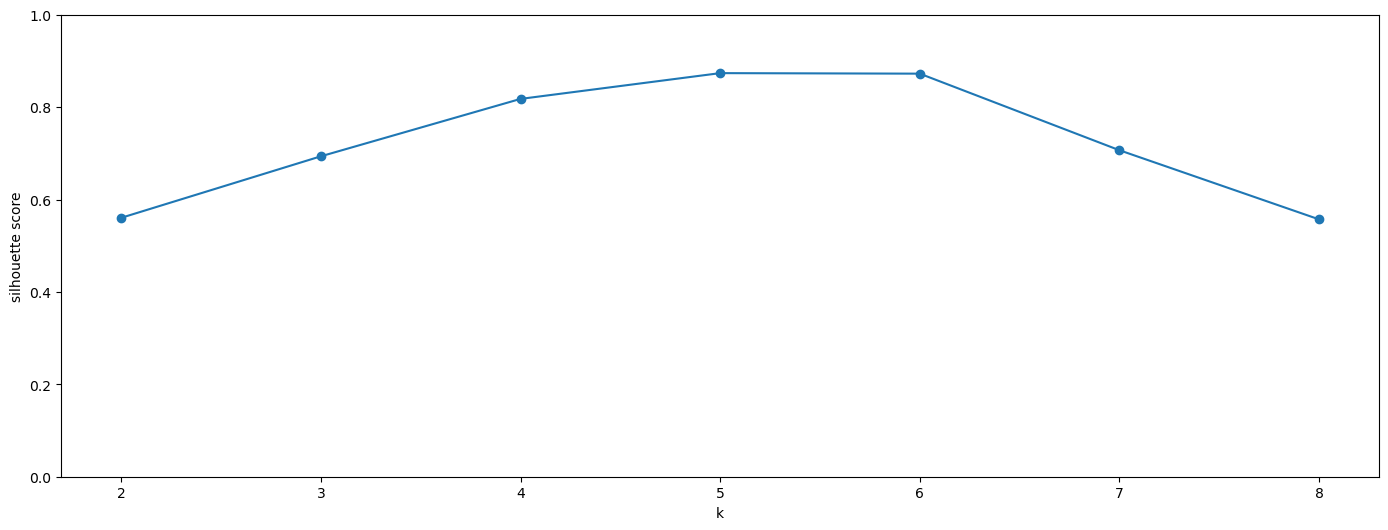

In [14]:
plt.figure(figsize=(17, 6))
plt.plot(range_n_clusters, sil_scores, 'o-')
plt.xlabel('k')
plt.ylabel(f'silhouette score')
plt.ylim((0, 1))
plt.savefig('../img/profiles_silhuette.png')
plt.show()

In [25]:
# optimal_n_clusters = range_n_clusters[np.argmax(sil_scores)] # 5 clusters are optimal
# print(f"optimal number of clusters (by silhouette score): {optimal_n_clusters}")
optimal_n_clusters = 5 # test this instead

In [27]:
%%time
print('k =',optimal_n_clusters)
kmedoids = KMedoids(n_clusters=optimal_n_clusters, metric='precomputed', method='pam', init='k-medoids++', random_state=42)
kmedoids.fit(gower_dist)

k= 5
CPU times: user 5min 45s, sys: 5.42 s, total: 5min 51s
Wall time: 5min 55s


KMedoids(init='k-medoids++', method='pam', metric='precomputed', n_clusters=5,
         random_state=42)

In [16]:
# save a copy of the kmedoids model
with open(INPROGRESS+'kmedoids_model_k5.pickle', 'wb+') as fh:
    pickle._dump(kmedoids, fh, protocol=pickle.HIGHEST_PROTOCOL)
# fetch anew 
# with open(INPROGRESS+'kmedoids_model_k5.pickle', 'rb') as fh:
#     kmedoids=pickle.load(fh)
# with open(INPROGRESS+'kmedoids_model_k6.pickle', 'rb') as fh:
#     kmedoids=pickle.load(fh)

In [17]:
# put cluster labels on the sitter profiles
profiles_df['cluster'] = kmedoids.labels_

In [18]:
%%time
# visualize the clusters using dimensionality reduction
# scaled distance matrix --> similarity matrix
similarity_matrix = 1 - gower_dist

# principal component analysis to reduce dataset to 2 dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(similarity_matrix)



In [19]:
# save a copy of the kmedoids model
with open(INPROGRESS+'profiles_dim_red_pca_k5.pickle', 'wb+') as fh:
    pickle._dump(pca_result, fh, protocol=pickle.HIGHEST_PROTOCOL)

# fetch anew 
# with open(INPROGRESS+'profiles_dim_red_pca_k5.pickle', 'rb') as fh:
#     pca_result=pickle.load(fh)
# with open(INPROGRESS+'profiles_dim_red_pca_k6.pickle', 'rb') as fh:
#     pca_result=pickle.load(fh)

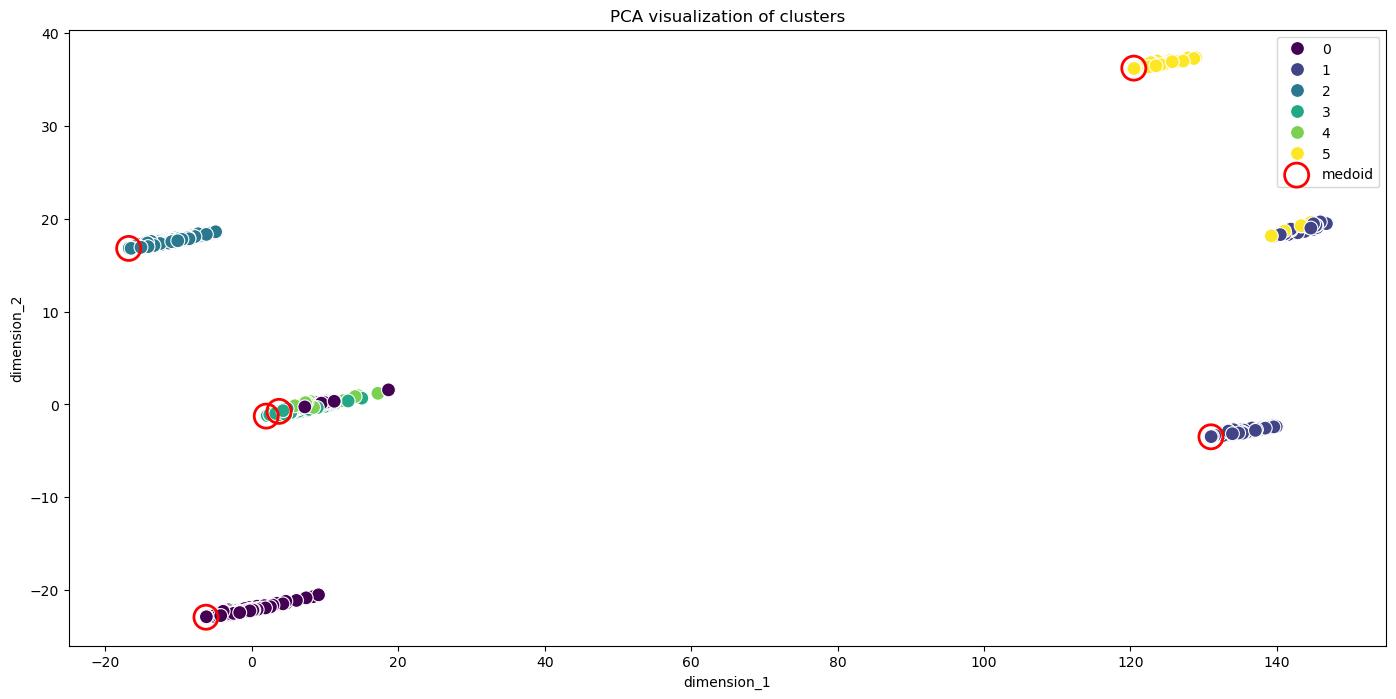

In [22]:
# a dataframe just for plotting
plot_df = pd.DataFrame({
    'dimension_1': pca_result[:, 0],
    'dimension_2': pca_result[:, 1],
    'cluster_label': profiles_df['cluster']
})

# Plot the clusters
plt.figure(figsize=(17, 8))
sns.scatterplot(x='dimension_1', y='dimension_2', hue='cluster_label', data=plot_df, palette='viridis', s=100)
# mark the medoids
for i, medoid_idx in enumerate(kmedoids.medoid_indices_):
    plt.scatter(pca_result[medoid_idx, 0], pca_result[medoid_idx, 1], 
                s=300, linewidth=2, 
                facecolors='none', edgecolors='red',
                label='medoid' if i == 0 else "")
plt.legend()
plt.title(f'PCA visualization of clusters of Housesitters profiles, k = {optimal_n_clusters}')
plt.savefig(f'../img/profiles_cluster_separation_k{optimal_n_clusters}.png')
plt.show()

- cluster 0 is split. some observations are tightly compact in the lower left and in a mixed cluster on the mid left, local 
- cluster 1 is itselft split into three subclusters but they all seem pure.
- cluster 2 is the only fully isolated and pure cluster
- cluster 3 and cluster 2 are mixed up with some of cluster 0

In [100]:
# cluster characteristics
display(profiles_df['cluster'].value_counts())

for cluster in range(optimal_n_clusters):
    print('-----------------------------------')
    print(f"cluster {cluster} characteristics:")
    cluster_data = profiles_df[profiles_df['cluster'] == cluster]
    print(f'cluster contains {len(cluster_data)} housesitters profiles')
    
    # feature distribution for categorical features
    for cat_col in categorical_features:
        if cat_col in profiles_df.columns:
            print(f"{cat_col} distribution:")
            # back to original categories
            original_values = encoders[cat_col].inverse_transform(cluster_data[cat_col].astype(int))
            value_distribution = pd.Series(original_values).value_counts(normalize=True)
            value_counts       = pd.Series(original_values).value_counts(normalize=False)
            # display(value_counts)
            display(value_distribution)
    
    # For numerical features, show summary statistics
    for num_col in numerical_features:
        if num_col in profiles_df.columns:
            print(f"{num_col} statistics:")
            print(cluster_data[num_col].describe())
    print('-----------------------------------')


cluster
2    15107
0    12278
3     2538
1     2128
4     1301
Name: count, dtype: int64

-----------------------------------
cluster 0 characteristics:
cluster contains 12278 housesitters profiles
travelling_as distribution:


FM    0.982489
MM    0.006434
N     0.002932
U     0.002036
FN    0.001303
X     0.001140
FX    0.000814
NN    0.000652
MU    0.000489
UU    0.000489
MN    0.000326
FU    0.000326
MX    0.000244
T     0.000163
NT    0.000163
Name: proportion, dtype: float64

with_children distribution:


False    1.0
Name: proportion, dtype: float64

sitting_with_another distribution:


True     0.989656
False    0.010344
Name: proportion, dtype: float64

occupation_type distribution:


employed                    0.299379
retired                     0.277796
self-employed               0.200458
working-while-travelling    0.140043
taking-time-off             0.082325
Name: proportion, dtype: float64

prev_sitting_experience distribution:


True     0.940055
False    0.059945
Name: proportion, dtype: float64

other_animals distribution:


True    1.0
Name: proportion, dtype: float64

has_dog_experience distribution:


True     0.971901
False    0.028099
Name: proportion, dtype: float64

has_cat_experience distribution:


True     0.954227
False    0.045773
Name: proportion, dtype: float64

has_reptile_experience distribution:


False    0.75957
True     0.24043
Name: proportion, dtype: float64

has_horse_experience distribution:


False    0.738964
True     0.261036
Name: proportion, dtype: float64

has_fish_experience distribution:


True     0.674377
False    0.325623
Name: proportion, dtype: float64

has_poultry_experience distribution:


True     0.510262
False    0.489738
Name: proportion, dtype: float64

has_farm_animal_experience distribution:


False    0.680648
True     0.319352
Name: proportion, dtype: float64

has_bird_experience distribution:


False    0.588207
True     0.411793
Name: proportion, dtype: float64

has_small_pet_experience distribution:


True     0.659146
False    0.340854
Name: proportion, dtype: float64

prefers_all_countries distribution:


True     0.641635
False    0.358365
Name: proportion, dtype: float64

happy_to_meet_in_person distribution:


True     0.996253
False    0.003747
Name: proportion, dtype: float64

happy_to_video_call distribution:


True     0.999674
False    0.000326
Name: proportion, dtype: float64

interested_in_remote_working distribution:


True     0.93696
False    0.06304
Name: proportion, dtype: float64

interested_in_dogs distribution:


False    0.878075
True     0.121925
Name: proportion, dtype: float64

interested_in_cats distribution:


False    0.874084
True     0.125916
Name: proportion, dtype: float64

interested_in_reptiles distribution:


False    0.940707
True     0.059293
Name: proportion, dtype: float64

interested_in_horses distribution:


False    0.955123
True     0.044877
Name: proportion, dtype: float64

interested_in_fish distribution:


False    0.893387
True     0.106613
Name: proportion, dtype: float64

interested_in_poultry distribution:


False    0.911631
True     0.088369
Name: proportion, dtype: float64

interested_in_farm_animals distribution:


False    0.943883
True     0.056117
Name: proportion, dtype: float64

interested_in_birds distribution:


False    0.923929
True     0.076071
Name: proportion, dtype: float64

interested_in_small_pets distribution:


False    0.891269
True     0.108731
Name: proportion, dtype: float64

with_a_baby distribution:


False    1.0
Name: proportion, dtype: float64

with_a_toddler distribution:


False    1.0
Name: proportion, dtype: float64

with_a_child distribution:


False    1.0
Name: proportion, dtype: float64

with_a_teen distribution:


False    1.0
Name: proportion, dtype: float64

dog_skills distribution:


False    0.790031
True     0.209969
Name: proportion, dtype: float64

cat_skills distribution:


False    0.769914
True     0.230086
Name: proportion, dtype: float64

can_give_medicine distribution:


False    0.793615
True     0.206385
Name: proportion, dtype: float64

big_dog_preferences distribution:


False    0.913993
True     0.086007
Name: proportion, dtype: float64

small_dog_preferences distribution:


False    0.900309
True     0.099691
Name: proportion, dtype: float64

wish_list_city distribution:


True     0.770647
False    0.229353
Name: proportion, dtype: float64

wish_list_beach distribution:


True     0.815116
False    0.184884
Name: proportion, dtype: float64

wish_list_mountain distribution:


True     0.780257
False    0.219743
Name: proportion, dtype: float64

wish_list_countryside distribution:


True     0.80013
False    0.19987
Name: proportion, dtype: float64

pct_complete statistics:
count    12278.000000
mean        88.446978
std          5.448097
min         76.000000
25%         84.000000
50%         84.000000
75%         94.000000
max        100.000000
Name: pct_complete, dtype: float64
nb_reviews statistics:
count    12278.000000
mean        10.427350
std         13.284908
min          0.000000
25%          2.000000
50%          6.000000
75%         14.000000
max        175.000000
Name: nb_reviews, dtype: float64
nb_5s_reviews statistics:
count    12278.000000
mean         9.871966
std         12.693743
min          0.000000
25%          2.000000
50%          5.000000
75%         13.000000
max        160.000000
Name: nb_5s_reviews, dtype: float64
nb_applications statistics:
count    12278.000000
mean        81.296791
std        119.551056
min          1.000000
25%         18.000000
50%         44.000000
75%         99.000000
max       3608.000000
Name: nb_applications, dtype: float64
nb_sits_completed statistics:
count    12278.000000


FM    0.631109
F     0.304511
FF    0.029135
M     0.026316
FX    0.002350
MM    0.001880
FN    0.001410
MX    0.000940
X     0.000940
UU    0.000470
MN    0.000470
N     0.000470
Name: proportion, dtype: float64

with_children distribution:


True    1.0
Name: proportion, dtype: float64

sitting_with_another distribution:


True     0.662124
False    0.337876
Name: proportion, dtype: float64

occupation_type distribution:


employed                    0.432203
self-employed               0.311676
working-while-travelling    0.146893
taking-time-off             0.088041
retired                     0.021186
Name: proportion, dtype: float64

prev_sitting_experience distribution:


True     0.930921
False    0.069079
Name: proportion, dtype: float64

other_animals distribution:


True    1.0
Name: proportion, dtype: float64

has_dog_experience distribution:


True     0.973214
False    0.026786
Name: proportion, dtype: float64

has_cat_experience distribution:


True     0.957237
False    0.042763
Name: proportion, dtype: float64

has_reptile_experience distribution:


False    0.726034
True     0.273966
Name: proportion, dtype: float64

has_horse_experience distribution:


False    0.68703
True     0.31297
Name: proportion, dtype: float64

has_fish_experience distribution:


True     0.729793
False    0.270207
Name: proportion, dtype: float64

has_poultry_experience distribution:


True     0.56532
False    0.43468
Name: proportion, dtype: float64

has_farm_animal_experience distribution:


False    0.630639
True     0.369361
Name: proportion, dtype: float64

has_bird_experience distribution:


False    0.574248
True     0.425752
Name: proportion, dtype: float64

has_small_pet_experience distribution:


True     0.75047
False    0.24953
Name: proportion, dtype: float64

prefers_all_countries distribution:


True     0.634868
False    0.365132
Name: proportion, dtype: float64

happy_to_meet_in_person distribution:


True     0.995301
False    0.004699
Name: proportion, dtype: float64

happy_to_video_call distribution:


True    1.0
Name: proportion, dtype: float64

interested_in_remote_working distribution:


True     0.966635
False    0.033365
Name: proportion, dtype: float64

interested_in_dogs distribution:


False    0.911184
True     0.088816
Name: proportion, dtype: float64

interested_in_cats distribution:


False    0.910244
True     0.089756
Name: proportion, dtype: float64

interested_in_reptiles distribution:


False    0.940789
True     0.059211
Name: proportion, dtype: float64

interested_in_horses distribution:


False    0.954887
True     0.045113
Name: proportion, dtype: float64

interested_in_fish distribution:


False    0.915883
True     0.084117
Name: proportion, dtype: float64

interested_in_poultry distribution:


False    0.922932
True     0.077068
Name: proportion, dtype: float64

interested_in_farm_animals distribution:


False    0.945959
True     0.054041
Name: proportion, dtype: float64

interested_in_birds distribution:


False    0.93609
True     0.06391
Name: proportion, dtype: float64

interested_in_small_pets distribution:


False    0.909774
True     0.090226
Name: proportion, dtype: float64

with_a_baby distribution:


False    0.734962
True     0.265038
Name: proportion, dtype: float64

with_a_toddler distribution:


False    0.721335
True     0.278665
Name: proportion, dtype: float64

with_a_child distribution:


False    0.604793
True     0.395207
Name: proportion, dtype: float64

with_a_teen distribution:


False    0.615602
True     0.384398
Name: proportion, dtype: float64

dog_skills distribution:


False    0.842105
True     0.157895
Name: proportion, dtype: float64

cat_skills distribution:


False    0.824718
True     0.175282
Name: proportion, dtype: float64

can_give_medicine distribution:


False    0.845865
True     0.154135
Name: proportion, dtype: float64

big_dog_preferences distribution:


False    0.93656
True     0.06344
Name: proportion, dtype: float64

small_dog_preferences distribution:


False    0.925752
True     0.074248
Name: proportion, dtype: float64

wish_list_city distribution:


True     0.763158
False    0.236842
Name: proportion, dtype: float64

wish_list_beach distribution:


True     0.846335
False    0.153665
Name: proportion, dtype: float64

wish_list_mountain distribution:


True     0.806391
False    0.193609
Name: proportion, dtype: float64

wish_list_countryside distribution:


True     0.827068
False    0.172932
Name: proportion, dtype: float64

pct_complete statistics:
count    2128.000000
mean       87.733083
std         5.424023
min        76.000000
25%        84.000000
50%        84.000000
75%        94.000000
max       100.000000
Name: pct_complete, dtype: float64
nb_reviews statistics:
count    2128.000000
mean        6.298872
std         9.052579
min         0.000000
25%         1.000000
50%         3.000000
75%         7.250000
max        95.000000
Name: nb_reviews, dtype: float64
nb_5s_reviews statistics:
count    2128.000000
mean        5.836936
std         8.519300
min         0.000000
25%         1.000000
50%         3.000000
75%         7.000000
max        88.000000
Name: nb_5s_reviews, dtype: float64
nb_applications statistics:
count    2128.000000
mean       73.270677
std       136.572704
min         1.000000
25%        13.000000
50%        32.000000
75%        77.000000
max      2288.000000
Name: nb_applications, dtype: float64
nb_sits_completed statistics:
count    2128.000000
mean        7.649436
std        1

F     0.997948
MM    0.000530
U     0.000463
N     0.000331
FN    0.000265
NN    0.000132
FU    0.000132
T     0.000066
X     0.000066
UU    0.000066
Name: proportion, dtype: float64

with_children distribution:


False    1.0
Name: proportion, dtype: float64

sitting_with_another distribution:


False    0.998875
True     0.001125
Name: proportion, dtype: float64

occupation_type distribution:


employed                    0.360103
self-employed               0.254261
working-while-travelling    0.179057
retired                     0.116321
taking-time-off             0.090258
Name: proportion, dtype: float64

prev_sitting_experience distribution:


True     0.937645
False    0.062355
Name: proportion, dtype: float64

other_animals distribution:


True    1.0
Name: proportion, dtype: float64

has_dog_experience distribution:


True     0.957106
False    0.042894
Name: proportion, dtype: float64

has_cat_experience distribution:


True     0.961011
False    0.038989
Name: proportion, dtype: float64

has_reptile_experience distribution:


False    0.784272
True     0.215728
Name: proportion, dtype: float64

has_horse_experience distribution:


False    0.770504
True     0.229496
Name: proportion, dtype: float64

has_fish_experience distribution:


True     0.638578
False    0.361422
Name: proportion, dtype: float64

has_poultry_experience distribution:


False    0.605547
True     0.394453
Name: proportion, dtype: float64

has_farm_animal_experience distribution:


False    0.742834
True     0.257166
Name: proportion, dtype: float64

has_bird_experience distribution:


False    0.644668
True     0.355332
Name: proportion, dtype: float64

has_small_pet_experience distribution:


True     0.618985
False    0.381015
Name: proportion, dtype: float64

prefers_all_countries distribution:


True     0.62984
False    0.37016
Name: proportion, dtype: float64

happy_to_meet_in_person distribution:


True     0.995764
False    0.004236
Name: proportion, dtype: float64

happy_to_video_call distribution:


True     0.999801
False    0.000199
Name: proportion, dtype: float64

interested_in_remote_working distribution:


True     0.964056
False    0.035944
Name: proportion, dtype: float64

interested_in_dogs distribution:


False    0.902893
True     0.097107
Name: proportion, dtype: float64

interested_in_cats distribution:


False    0.889257
True     0.110743
Name: proportion, dtype: float64

interested_in_reptiles distribution:


False    0.957238
True     0.042762
Name: proportion, dtype: float64

interested_in_horses distribution:


False    0.968624
True     0.031376
Name: proportion, dtype: float64

interested_in_fish distribution:


False    0.915668
True     0.084332
Name: proportion, dtype: float64

interested_in_poultry distribution:


False    0.938638
True     0.061362
Name: proportion, dtype: float64

interested_in_farm_animals distribution:


False    0.962931
True     0.037069
Name: proportion, dtype: float64

interested_in_birds distribution:


False    0.940888
True     0.059112
Name: proportion, dtype: float64

interested_in_small_pets distribution:


False    0.912094
True     0.087906
Name: proportion, dtype: float64

with_a_baby distribution:


False    1.0
Name: proportion, dtype: float64

with_a_toddler distribution:


False    1.0
Name: proportion, dtype: float64

with_a_child distribution:


False    1.0
Name: proportion, dtype: float64

with_a_teen distribution:


False    1.0
Name: proportion, dtype: float64

dog_skills distribution:


False    0.841663
True     0.158337
Name: proportion, dtype: float64

cat_skills distribution:


False    0.818561
True     0.181439
Name: proportion, dtype: float64

can_give_medicine distribution:


False    0.842523
True     0.157477
Name: proportion, dtype: float64

big_dog_preferences distribution:


False    0.940756
True     0.059244
Name: proportion, dtype: float64

small_dog_preferences distribution:


False    0.922817
True     0.077183
Name: proportion, dtype: float64

wish_list_city distribution:


True     0.796783
False    0.203217
Name: proportion, dtype: float64

wish_list_beach distribution:


True     0.821937
False    0.178063
Name: proportion, dtype: float64

wish_list_mountain distribution:


True     0.748792
False    0.251208
Name: proportion, dtype: float64

wish_list_countryside distribution:


True     0.75753
False    0.24247
Name: proportion, dtype: float64

pct_complete statistics:
count    15107.000000
mean        87.780499
std          5.379397
min         76.000000
25%         84.000000
50%         84.000000
75%         94.000000
max        100.000000
Name: pct_complete, dtype: float64
nb_reviews statistics:
count    15107.000000
mean         8.215728
std         11.138804
min          0.000000
25%          1.000000
50%          4.000000
75%         10.000000
max        135.000000
Name: nb_reviews, dtype: float64
nb_5s_reviews statistics:
count    15107.000000
mean         7.585623
std         10.445150
min          0.000000
25%          1.000000
50%          4.000000
75%         10.000000
max        127.000000
Name: nb_5s_reviews, dtype: float64
nb_applications statistics:
count    15107.000000
mean        83.909976
std        145.996807
min          1.000000
25%         17.000000
50%         40.000000
75%         95.000000
max       4233.000000
Name: nb_applications, dtype: float64
nb_sits_completed statistics:
count    15107.000000


M     0.982664
MM    0.007880
FX    0.002364
N     0.001970
U     0.001182
FU    0.000788
NN    0.000788
FN    0.000394
T     0.000394
X     0.000394
MN    0.000394
UU    0.000394
MX    0.000394
Name: proportion, dtype: float64

with_children distribution:


False    1.0
Name: proportion, dtype: float64

sitting_with_another distribution:


False    0.986604
True     0.013396
Name: proportion, dtype: float64

occupation_type distribution:


employed                    0.334520
self-employed               0.265322
working-while-travelling    0.192171
retired                     0.134440
taking-time-off             0.073547
Name: proportion, dtype: float64

prev_sitting_experience distribution:


True     0.927502
False    0.072498
Name: proportion, dtype: float64

other_animals distribution:


True    1.0
Name: proportion, dtype: float64

has_dog_experience distribution:


True     0.965327
False    0.034673
Name: proportion, dtype: float64

has_cat_experience distribution:


True     0.958235
False    0.041765
Name: proportion, dtype: float64

has_reptile_experience distribution:


False    0.743893
True     0.256107
Name: proportion, dtype: float64

has_horse_experience distribution:


False    0.802206
True     0.197794
Name: proportion, dtype: float64

has_fish_experience distribution:


True     0.62766
False    0.37234
Name: proportion, dtype: float64

has_poultry_experience distribution:


False    0.600079
True     0.399921
Name: proportion, dtype: float64

has_farm_animal_experience distribution:


False    0.724192
True     0.275808
Name: proportion, dtype: float64

has_bird_experience distribution:


False    0.631994
True     0.368006
Name: proportion, dtype: float64

has_small_pet_experience distribution:


True     0.58747
False    0.41253
Name: proportion, dtype: float64

prefers_all_countries distribution:


True     0.62569
False    0.37431
Name: proportion, dtype: float64

happy_to_meet_in_person distribution:


True     0.999212
False    0.000788
Name: proportion, dtype: float64

happy_to_video_call distribution:


True     0.999212
False    0.000788
Name: proportion, dtype: float64

interested_in_remote_working distribution:


True     0.973995
False    0.026005
Name: proportion, dtype: float64

interested_in_dogs distribution:


False    0.92435
True     0.07565
Name: proportion, dtype: float64

interested_in_cats distribution:


False    0.913712
True     0.086288
Name: proportion, dtype: float64

interested_in_reptiles distribution:


False    0.951143
True     0.048857
Name: proportion, dtype: float64

interested_in_horses distribution:


False    0.970055
True     0.029945
Name: proportion, dtype: float64

interested_in_fish distribution:


False    0.931442
True     0.068558
Name: proportion, dtype: float64

interested_in_poultry distribution:


False    0.947991
True     0.052009
Name: proportion, dtype: float64

interested_in_farm_animals distribution:


False    0.961781
True     0.038219
Name: proportion, dtype: float64

interested_in_birds distribution:


False    0.948779
True     0.051221
Name: proportion, dtype: float64

interested_in_small_pets distribution:


False    0.931048
True     0.068952
Name: proportion, dtype: float64

with_a_baby distribution:


False    1.0
Name: proportion, dtype: float64

with_a_toddler distribution:


False    1.0
Name: proportion, dtype: float64

with_a_child distribution:


False    1.0
Name: proportion, dtype: float64

with_a_teen distribution:


False    1.0
Name: proportion, dtype: float64

dog_skills distribution:


False    0.853428
True     0.146572
Name: proportion, dtype: float64

cat_skills distribution:


False    0.835303
True     0.164697
Name: proportion, dtype: float64

can_give_medicine distribution:


False    0.86052
True     0.13948
Name: proportion, dtype: float64

big_dog_preferences distribution:


False    0.943656
True     0.056344
Name: proportion, dtype: float64

small_dog_preferences distribution:


False    0.940898
True     0.059102
Name: proportion, dtype: float64

wish_list_city distribution:


True     0.815209
False    0.184791
Name: proportion, dtype: float64

wish_list_beach distribution:


True     0.803783
False    0.196217
Name: proportion, dtype: float64

wish_list_mountain distribution:


True     0.782506
False    0.217494
Name: proportion, dtype: float64

wish_list_countryside distribution:


True     0.773838
False    0.226162
Name: proportion, dtype: float64

pct_complete statistics:
count    2538.000000
mean       87.439716
std         5.452749
min        76.000000
25%        84.000000
50%        84.000000
75%        94.000000
max       100.000000
Name: pct_complete, dtype: float64
nb_reviews statistics:
count    2538.000000
mean        9.912136
std        14.220813
min         0.000000
25%         1.000000
50%         4.000000
75%        12.000000
max       149.000000
Name: nb_reviews, dtype: float64
nb_5s_reviews statistics:
count    2538.000000
mean        8.955477
std        13.102669
min         0.000000
25%         1.000000
50%         4.000000
75%        11.000000
max       143.000000
Name: nb_5s_reviews, dtype: float64
nb_applications statistics:
count    2538.000000
mean      104.122537
std       203.943121
min         1.000000
25%        14.250000
50%        41.000000
75%       109.000000
max      3826.000000
Name: nb_applications, dtype: float64
nb_sits_completed statistics:
count    2538.000000
mean       12.176517
std        1

FF    0.868563
MM    0.044581
N     0.028440
X     0.009224
U     0.008455
FN    0.007686
FX    0.006149
FU    0.005380
MX    0.004612
T     0.003843
NN    0.003075
UU    0.003075
MN    0.002306
MU    0.001537
NU    0.001537
FT    0.000769
MT    0.000769
Name: proportion, dtype: float64

with_children distribution:


False    1.0
Name: proportion, dtype: float64

sitting_with_another distribution:


True     0.942352
False    0.057648
Name: proportion, dtype: float64

occupation_type distribution:


employed                    0.422958
working-while-travelling    0.197997
self-employed               0.186441
taking-time-off             0.109399
retired                     0.083205
Name: proportion, dtype: float64

prev_sitting_experience distribution:


True     0.933128
False    0.066872
Name: proportion, dtype: float64

other_animals distribution:


True    1.0
Name: proportion, dtype: float64

has_dog_experience distribution:


True     0.976172
False    0.023828
Name: proportion, dtype: float64

has_cat_experience distribution:


True     0.956956
False    0.043044
Name: proportion, dtype: float64

has_reptile_experience distribution:


False    0.764796
True     0.235204
Name: proportion, dtype: float64

has_horse_experience distribution:


False    0.767871
True     0.232129
Name: proportion, dtype: float64

has_fish_experience distribution:


True     0.634896
False    0.365104
Name: proportion, dtype: float64

has_poultry_experience distribution:


False    0.58186
True     0.41814
Name: proportion, dtype: float64

has_farm_animal_experience distribution:


False    0.71176
True     0.28824
Name: proportion, dtype: float64

has_bird_experience distribution:


False    0.653344
True     0.346656
Name: proportion, dtype: float64

has_small_pet_experience distribution:


True     0.650269
False    0.349731
Name: proportion, dtype: float64

prefers_all_countries distribution:


True     0.650269
False    0.349731
Name: proportion, dtype: float64

happy_to_meet_in_person distribution:


True     0.995388
False    0.004612
Name: proportion, dtype: float64

happy_to_video_call distribution:


True    1.0
Name: proportion, dtype: float64

interested_in_remote_working distribution:


True     0.973098
False    0.026902
Name: proportion, dtype: float64

interested_in_dogs distribution:


False    0.928517
True     0.071483
Name: proportion, dtype: float64

interested_in_cats distribution:


False    0.92083
True     0.07917
Name: proportion, dtype: float64

interested_in_reptiles distribution:


False    0.966949
True     0.033051
Name: proportion, dtype: float64

interested_in_horses distribution:


False    0.970792
True     0.029208
Name: proportion, dtype: float64

interested_in_fish distribution:


False    0.939277
True     0.060723
Name: proportion, dtype: float64

interested_in_poultry distribution:


False    0.948501
True     0.051499
Name: proportion, dtype: float64

interested_in_farm_animals distribution:


False    0.963105
True     0.036895
Name: proportion, dtype: float64

interested_in_birds distribution:


False    0.956956
True     0.043044
Name: proportion, dtype: float64

interested_in_small_pets distribution:


False    0.936203
True     0.063797
Name: proportion, dtype: float64

with_a_baby distribution:


False    1.0
Name: proportion, dtype: float64

with_a_toddler distribution:


False    1.0
Name: proportion, dtype: float64

with_a_child distribution:


False    1.0
Name: proportion, dtype: float64

with_a_teen distribution:


False    1.0
Name: proportion, dtype: float64

dog_skills distribution:


False    0.861645
True     0.138355
Name: proportion, dtype: float64

cat_skills distribution:


False    0.850115
True     0.149885
Name: proportion, dtype: float64

can_give_medicine distribution:


False    0.863951
True     0.136049
Name: proportion, dtype: float64

big_dog_preferences distribution:


False    0.955419
True     0.044581
Name: proportion, dtype: float64

small_dog_preferences distribution:


False    0.944658
True     0.055342
Name: proportion, dtype: float64

wish_list_city distribution:


True     0.830899
False    0.169101
Name: proportion, dtype: float64

wish_list_beach distribution:


True     0.827056
False    0.172944
Name: proportion, dtype: float64

wish_list_mountain distribution:


True     0.764796
False    0.235204
Name: proportion, dtype: float64

wish_list_countryside distribution:


True     0.781706
False    0.218294
Name: proportion, dtype: float64

pct_complete statistics:
count    1301.000000
mean       87.154497
std         5.078306
min        76.000000
25%        84.000000
50%        84.000000
75%        94.000000
max       100.000000
Name: pct_complete, dtype: float64
nb_reviews statistics:
count    1301.000000
mean        6.021522
std        10.427530
min         0.000000
25%         1.000000
50%         2.000000
75%         7.000000
max       158.000000
Name: nb_reviews, dtype: float64
nb_5s_reviews statistics:
count    1301.000000
mean        5.639508
std         9.876777
min         0.000000
25%         1.000000
50%         2.000000
75%         6.000000
max       158.000000
Name: nb_5s_reviews, dtype: float64
nb_applications statistics:
count    1301.000000
mean       62.533436
std       170.305937
min         1.000000
25%        12.000000
50%        28.000000
75%        70.000000
max      5388.000000
Name: nb_applications, dtype: float64
nb_sits_completed statistics:
count    1301.000000
mean        7.179862
std        1

In [ ]:
def calculate_feature_importance(data, cluster_labels, n_clusters=5):
    importances = {}
    
    for cluster in range(n_clusters):
        cluster_data = data[cluster_labels == cluster]
        cluster_size = len(cluster_data)
        total_size = len(data)
        
        feature_importances = {}
        
        for feature in data.columns:
            # For categorical features, look at each category
            if data[feature].dtype == 'object' or data[feature].dtype == 'bool':
                for category in data[feature].unique():
                    # Proportion in cluster with this category
                    prop_in_cluster = (cluster_data[feature] == category).mean()
                    # Proportion in overall dataset with this category
                    prop_overall = (data[feature] == category).mean()
                    
                    # Avoid division by zero
                    if prop_overall > 0:
                        # Lift/importance score
                        importance = prop_in_cluster / prop_overall
                        feature_importances[f"{feature}_{category}"] = importance
            
        # Sort by importance (descending)
        sorted_importances = dict(sorted(feature_importances.items(), 
                                        key=lambda x: abs(x[1]-1), 
                                        reverse=True))
        importances[f"Cluster_{cluster}"] = sorted_importances
    
    return importances


In [89]:
import umap.umap_ as umap
reducer = umap.UMAP()

- NTF: number of dims in which the first value is True, second is False = 2.
- NFT: number of dims in which the first value is False, second is True = 1.
- NNEQ : number of non-equal dimensions, NNEQ = NTF + NFT = 3.
- NTT : number of dims in which both values are True = 0.
- NNZ : number of nonzero dimensions, NNZ = NTF + NFT + NTT = 3.
- DiceDistance = NNEQ / (NTT + NNZ) = 3/3 = 1